## Run likelihood scan for $A_s$, using full_theory

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 140
mpl.rcParams['figure.dpi'] = 140
# our modules
import data_MPGADGET
import p1d_arxiv
import gp_emulator
import likelihood
import likelihood_parameter
import lya_theory
import full_theory
import camb_cosmo
import CAMB_model
import fit_linP

In [2]:
# specify verbosity for all objects (except emulator)
verbose=False

### Setup mock data, from one of simulations in the suite

In [3]:
# specify simulation suite and P1D mesurements
basedir="/p1d_emulator/sim_suites/Australia20/"
skewers_label='Ns500_wM0.05'
p1d_label=None
# specify simulation to use to generate synthetic data (this is the simulation for our default model)
test_sim_num=30
data=data_MPGADGET.P1D_MPGADGET(sim_number=test_sim_num,basedir=basedir,skewers_label=skewers_label)

### Setup archive of P1D measurements from simulations and train the emulator

In [4]:
# specify redshift range
z_max=4
# do not use test_sim_num that was used in generating mock data
arxiv=p1d_arxiv.ArxivP1D(basedir=basedir,drop_sim_number=test_sim_num,
                            drop_tau_rescalings=True,z_max=z_max,
                            drop_temp_rescalings=True,skewers_label=skewers_label)
arxiv_complete=p1d_arxiv.ArxivP1D(basedir=basedir,
                            drop_tau_rescalings=True,z_max=z_max,
                            drop_temp_rescalings=True,skewers_label=skewers_label)

In [5]:
# specify parameters to be used in emulator
paramList=['mF', 'sigT_Mpc', 'gamma', 'kF_Mpc', 'Delta2_p', 'n_p']
# specify k range
kmax_Mpc=8
# setup GP emulator
emu=gp_emulator.GPEmulator(basedir,p1d_label,skewers_label,z_max=z_max,
                                verbose=False,paramList=paramList,train=True,
                                emu_type="k_bin",passArxiv=arxiv,kmax_Mpc=kmax_Mpc,
                                drop_tau_rescalings=True,
                                drop_temp_rescalings=True)

 /home/chris/.local/lib/python3.8/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!


Training GP on 270 points
Optimised


In [6]:
emu_complete=gp_emulator.GPEmulator(basedir,p1d_label,skewers_label,z_max=z_max,
                                verbose=False,paramList=paramList,train=True,
                                emu_type="k_bin",passArxiv=arxiv_complete,kmax_Mpc=kmax_Mpc,
                                drop_tau_rescalings=True,
                                drop_temp_rescalings=True)

Training GP on 279 points
Optimised


### Setup likelihood object, with full theory, and using the truth as fiducial model

In [7]:
free_params=["As"]
like=likelihood.Likelihood(data=data,emulator=emu,
                            free_parameters=free_params,
                            free_param_limits=None,
                            verbose=verbose,
                            prior_Gauss_rms=0.15,
                            emu_cov_factor=1)
like_complete=likelihood.Likelihood(data=data,emulator=emu_complete,
                            free_parameters=free_params,
                            free_param_limits=None,
                            verbose=verbose,
                            prior_Gauss_rms=0.15,
                            emu_cov_factor=1)

In [8]:
# print default cosmology
for par in like.theory.camb_model_fid.get_likelihood_parameters():
    print(par.info_str(),', in cube =',par.value_in_cube())

ombh2 = 0.022000140100000003 , in cube = 0.5000233500000004
omch2 = 0.11999994800000002 , in cube = 0.39999896000000046
As = 2.006055e-09 , in cube = 0.030274999999999712
ns = 0.967565 , in cube = 0.5855000000000012
H0 = 67.0 , in cube = 0.2857142857142857
mnu = 0.0 , in cube = 0.0


In [9]:
# identify parameter we are interested in
par=like.get_parameter_by_name('As')
true_As=par.value

In [10]:
# setup grid of As values to evaluate
NAs=21
Asmin=1.9e-9
Asmax=2.2e-9
As=np.linspace(Asmin,Asmax,NAs)
log_like=np.empty(NAs)
log_like_complete=np.empty(NAs)

In [11]:
for i in range(NAs):
    # I hate python (you should not be allowed to do this)
    par.value=As[i]
    log_like[i]=like.get_log_like(values=[par.value_in_cube()],ignore_log_det_cov=True)
    log_like_complete[i]=like_complete.get_log_like(values=[par.value_in_cube()],ignore_log_det_cov=True)
    print(i,As[i],log_like[i])
    print(i,As[i],log_like_complete[i])

0 1.9e-09 -24.219449451615677
0 1.9e-09 -28.182084409533047
1 1.915e-09 -20.235177091221914
1 1.915e-09 -23.644787926450242
2 1.93e-09 -16.551744231485543
2 1.93e-09 -19.309207494181056
3 1.9450000000000002e-09 -13.20850876722476
3 1.9450000000000002e-09 -15.241053311769443
4 1.96e-09 -10.240440780678197
4 1.96e-09 -11.512473363626167
5 1.975e-09 -7.676867579643614
5 1.975e-09 -8.200018774007455
6 1.99e-09 -5.540382579393294
6 1.99e-09 -5.381218384118094
7 2.005e-09 -3.845999467723088
7 2.005e-09 -3.129627996290803
8 2.02e-09 -2.600622350692965
8 2.02e-09 -1.5085535517426159
9 2.035e-09 -1.8028819049247362
9 2.035e-09 -0.5641219342449236
10 2.05e-09 -1.443359318824166
10 2.05e-09 -0.3188762211617062
11 2.065e-09 -1.5051867166582695
11 2.065e-09 -0.7673575703260659
12 2.08e-09 -1.9649788294308004
12 2.08e-09 -1.8749663294879217
13 2.095e-09 -2.79402213403732
13 2.095e-09 -3.5806903975856246
14 2.11e-09 -3.9596278190605343
14 2.11e-09 -5.803269628567305
15 2.125e-09 -5.426547085439936
15

Text(0, 0.5, 'Log Likelihood')

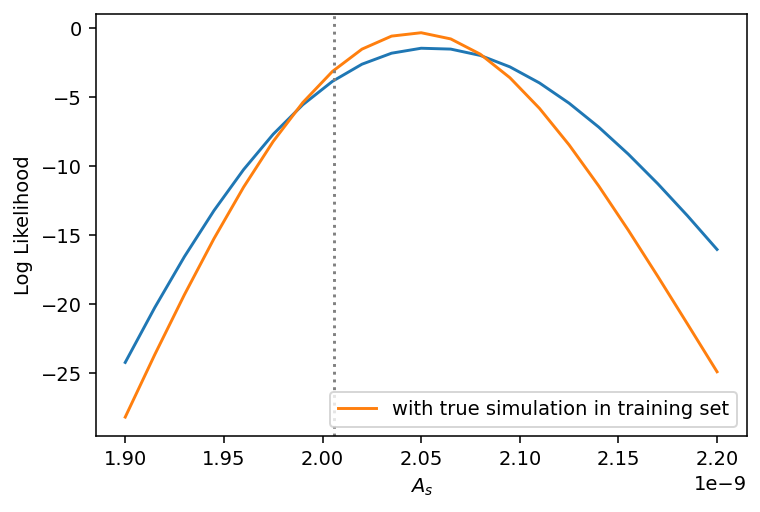

In [16]:
plt.plot(As,log_like)
plt.plot(As,log_like_complete,label="with true simulation in training set")
plt.axvline(x=true_As,ls=':',color='gray')
plt.xlabel(r'$A_s$')
plt.legend()
plt.ylabel(r'Log Likelihood')

These results are not horrible, but not great either... 
Given that there is no noise, and no approximations, the 2% bias in $A_s$ is probably caused by the emulator.

### CP
So the bias is improved a bit by including the test simulation in the training set, but not totally eliminated.

What are some ways we can investigate? First I'll plot the ratio of the predicted P1D with the truth, both in comoving and velocity. Is the emulator returning a poor prediction at the true values? Or is there some kind of bug, where the other fiducial values aren't being set properly for example.

In [13]:
## Plot the predicted predicted P1D/true P1D in comoving units
## Create arxiv object for true p1d
truth=p1d_arxiv.ArxivP1D(basedir=basedir,
                            drop_tau_rescalings=True,z_max=4,pick_sim_number=test_sim_num,
                            drop_temp_rescalings=True,skewers_label=skewers_label)
## Set up k bins for emulator call
k_test=truth.data[1]["k_Mpc"][1:]
k_test=k_test[k_test<7]

Text(0.5, 0, 'k 1/Mpc')

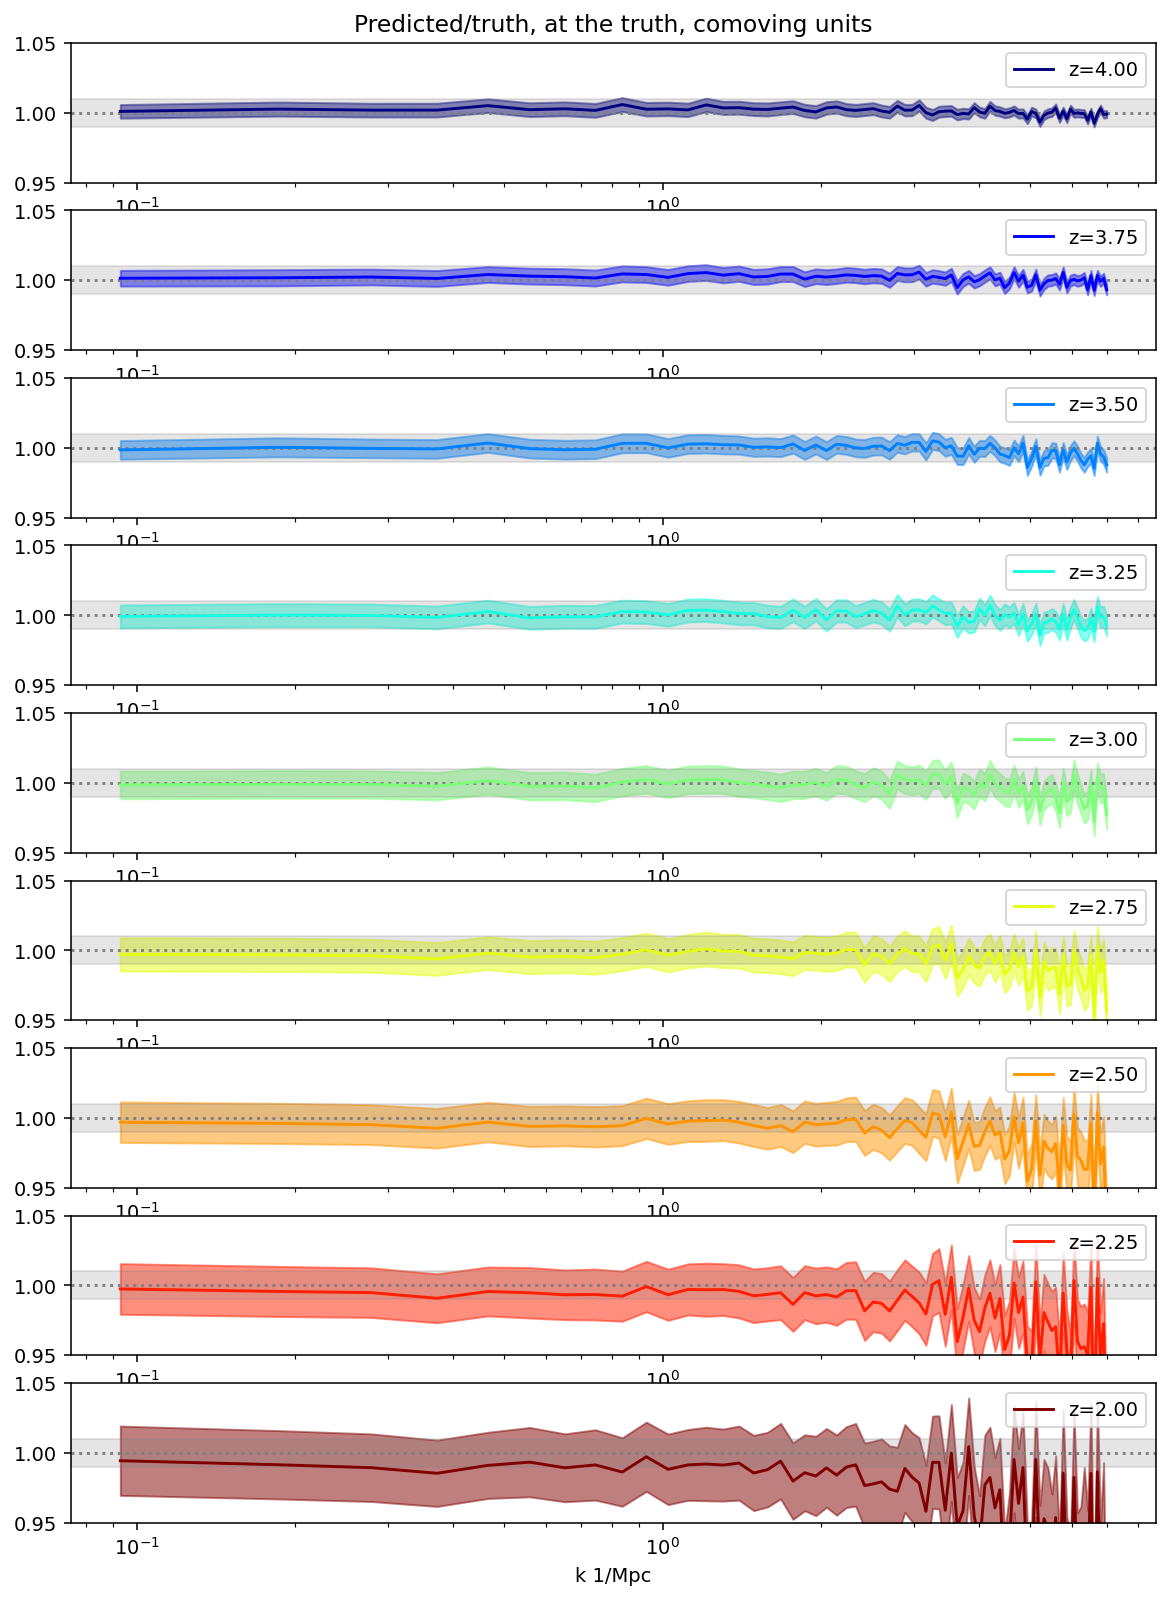

In [14]:
plt.figure(figsize=[10,14])
dex=0
for aa,item in enumerate(truth.data):
    plt.subplot(len(truth.data),1,aa+1)
    if aa==0:
        plt.title("Predicted/truth, at the truth, comoving units")
    col = plt.cm.jet(dex/(len(truth.data)-1))
    dex+=1
    emu_call={}
    for param in paramList:
        emu_call[param]=item[param]
    pred,err=emu.emulate_p1d_Mpc(emu_call,k_test,True,item["z"])
    plt.axhspan(0.99,1.01,color="gray",alpha=0.2)
    plt.axhline(1,linestyle=":",color="gray")
    ## Plot z with different limits
    plt.plot(k_test,pred/item["p1d_Mpc"][1:(len(k_test)+1)],color=col,linestyle="solid",label="z=%.2f" % item["z"])
    plt.fill_between(k_test,(pred+np.sqrt(np.diag(err)))/item["p1d_Mpc"][1:(len(k_test)+1)],
            (pred-np.sqrt(np.diag(err)))/item["p1d_Mpc"][1:(len(k_test)+1)],alpha=0.5,color=col)

    plt.xscale("log")
    plt.ylim(0.95,1.05)
    plt.legend()

#plt.xscale("log")
plt.xlabel("k 1/Mpc")

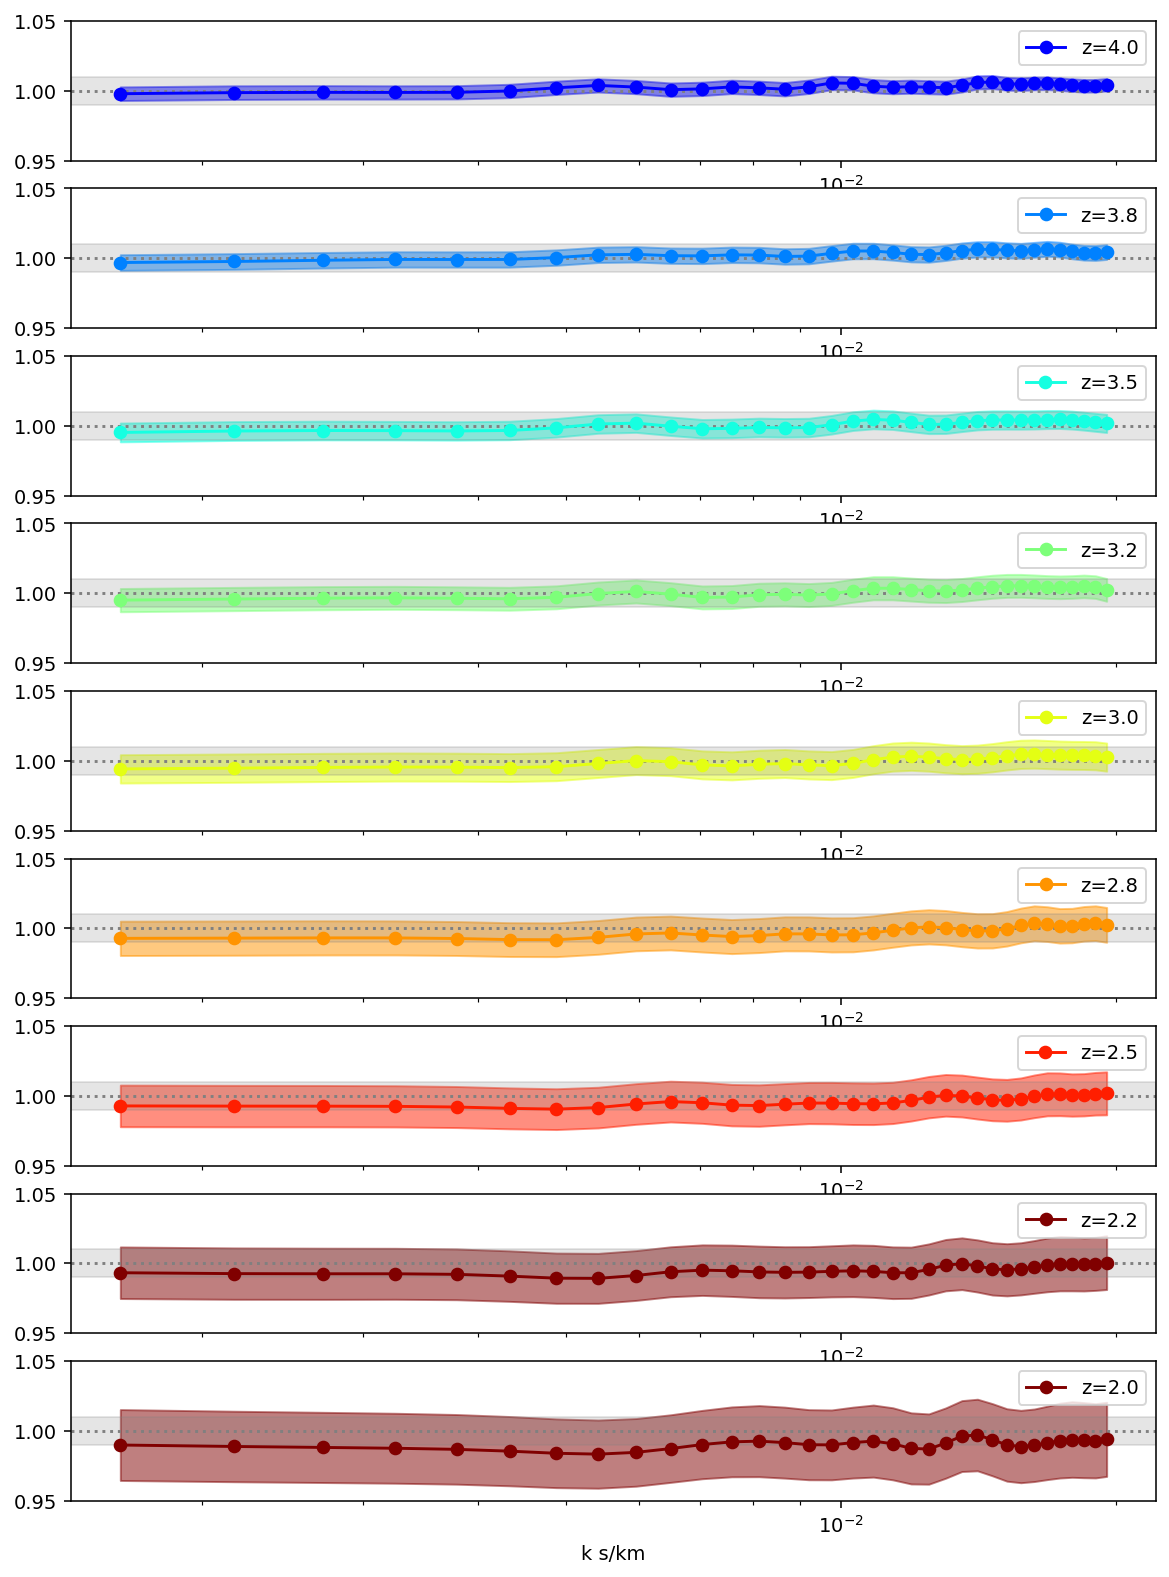

In [17]:
k_kms=data.k
k_emu_kms=np.logspace(np.log10(min(k_kms)),np.log10(max(k_kms)),500)
zs=data.z
Nz=len(zs)

# ask emulator prediction for P1D in each bin
emu_p1d, emu_cov = like.get_p1d_kms(k_kms,values=None,return_covar=True)

emu_calls=like.theory.get_emulator_calls(like.parameters_from_sampling_point(values=None))

plt.figure(figsize=[10,14])
dex=0
# plot only few redshifts for clarity
for iz in reversed(range(0,Nz)):
    plt.subplot(len(truth.data),1,len(truth.data)-(iz))
    if aa==0:
        plt.title("Predicted/truth, at the truth, velocity units")
    # acess data for this redshift
    z=zs[iz]
    p1d_data=data.get_Pk_iz(iz)
    p1d_cov=data.get_cov_iz(iz)
    p1d_theory=emu_p1d[iz]
    cov_theory=emu_cov[iz]
    
    # plot everything
    col = plt.cm.jet((len(truth.data)-iz)/(Nz-1))
    plt.axhspan(0.99,1.01,color="gray",alpha=0.2)
    plt.axhline(1,linestyle=":",color="gray")
    plt.plot(k_kms,p1d_theory/p1d_data,color=col,linestyle="solid",marker="o",label="z=%.1f" % z)
    plt.fill_between(k_kms,(p1d_theory+np.sqrt(np.diag(cov_theory)))/p1d_data,
            (p1d_theory-np.sqrt(np.diag(cov_theory)))/p1d_data,alpha=0.5,color=col)
    plt.xscale("log")
    plt.ylim(0.95,1.05)
    plt.legend()
    
plt.xlabel("k s/km")
plt.show()

## Emulator prediction with the 'complete' arxiv

Just to demonstrate that the predictions are 'perfect' at the truth when we include the test simulation in the training set

Text(0.5, 0, 'k 1/Mpc')

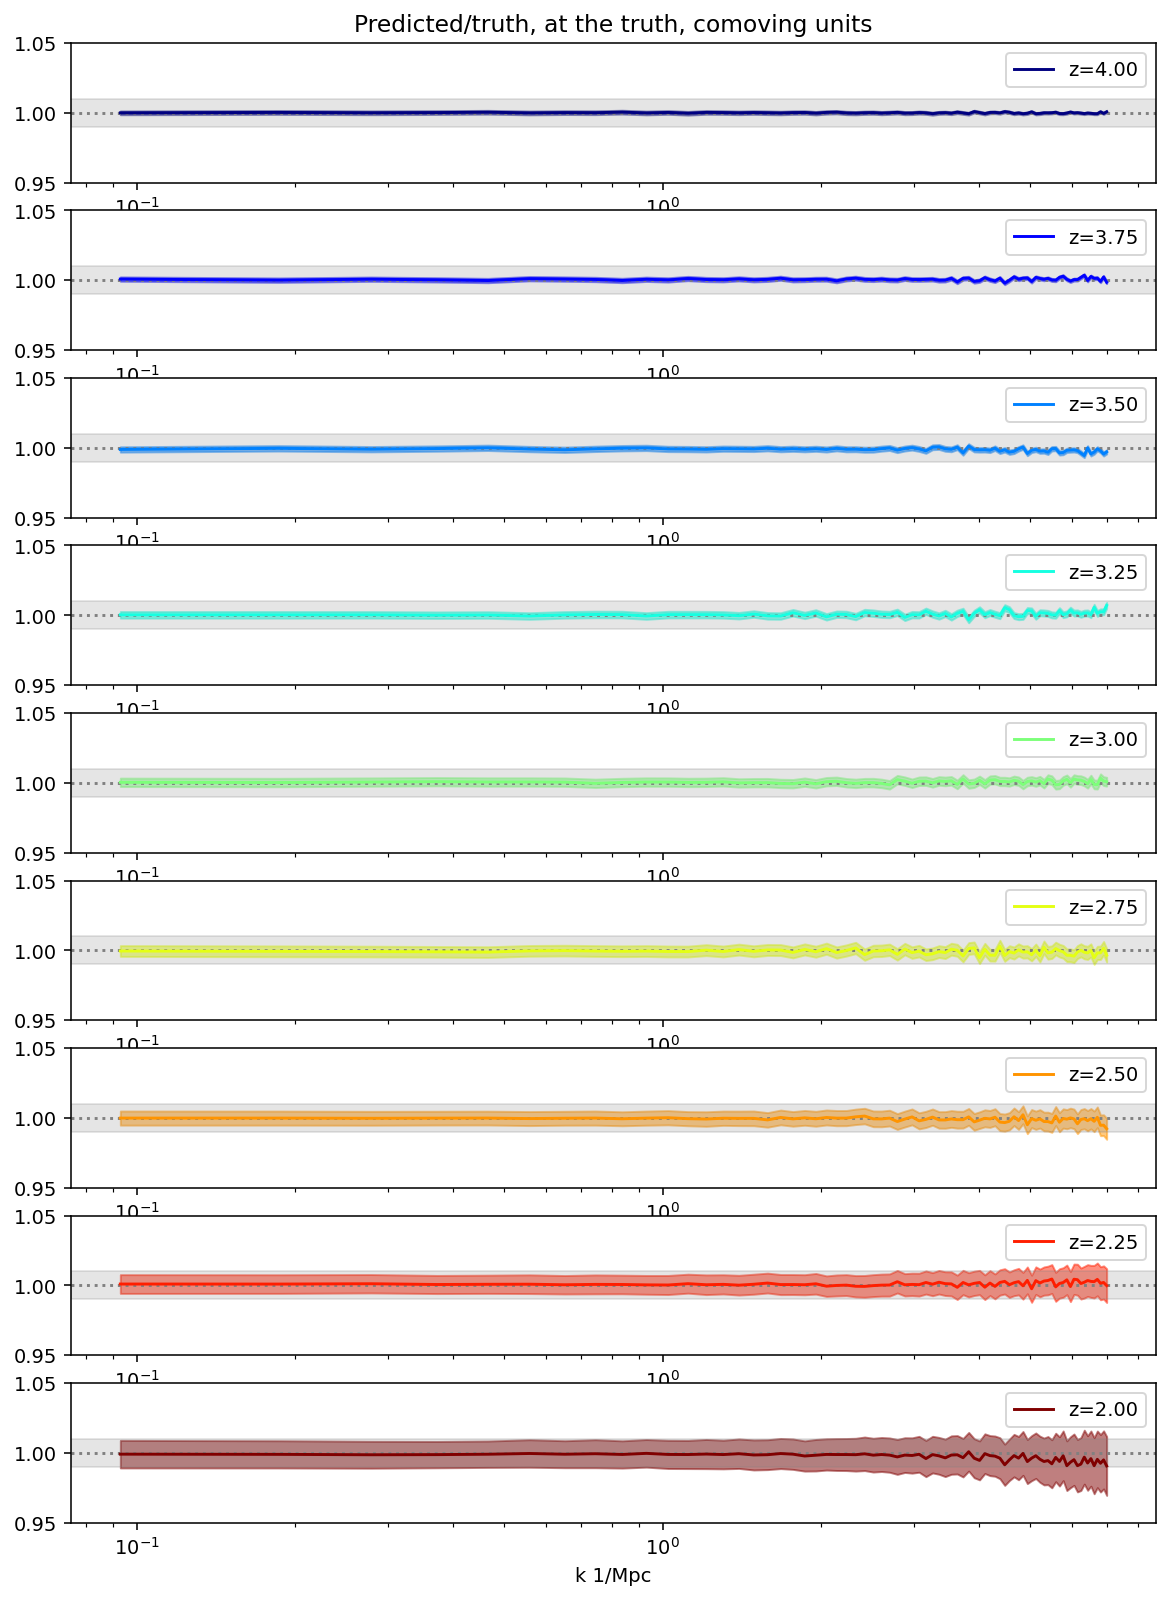

In [19]:
plt.figure(figsize=[10,14])
dex=0
for aa,item in enumerate(truth.data):
    plt.subplot(len(truth.data),1,aa+1)
    if aa==0:
        plt.title("Predicted/truth, at the truth, comoving units")
    col = plt.cm.jet(dex/(len(truth.data)-1))
    dex+=1
    emu_call={}
    for param in paramList:
        emu_call[param]=item[param]
    pred,err=emu_complete.emulate_p1d_Mpc(emu_call,k_test,True,item["z"])
    plt.axhspan(0.99,1.01,color="gray",alpha=0.2)
    plt.axhline(1,linestyle=":",color="gray")
    ## Plot z with different limits
    plt.plot(k_test,pred/item["p1d_Mpc"][1:(len(k_test)+1)],color=col,linestyle="solid",label="z=%.2f" % item["z"])
    plt.fill_between(k_test,(pred+np.sqrt(np.diag(err)))/item["p1d_Mpc"][1:(len(k_test)+1)],
            (pred-np.sqrt(np.diag(err)))/item["p1d_Mpc"][1:(len(k_test)+1)],alpha=0.5,color=col)

    plt.xscale("log")
    plt.ylim(0.95,1.05)
    plt.legend()

#plt.xscale("log")
plt.xlabel("k 1/Mpc")

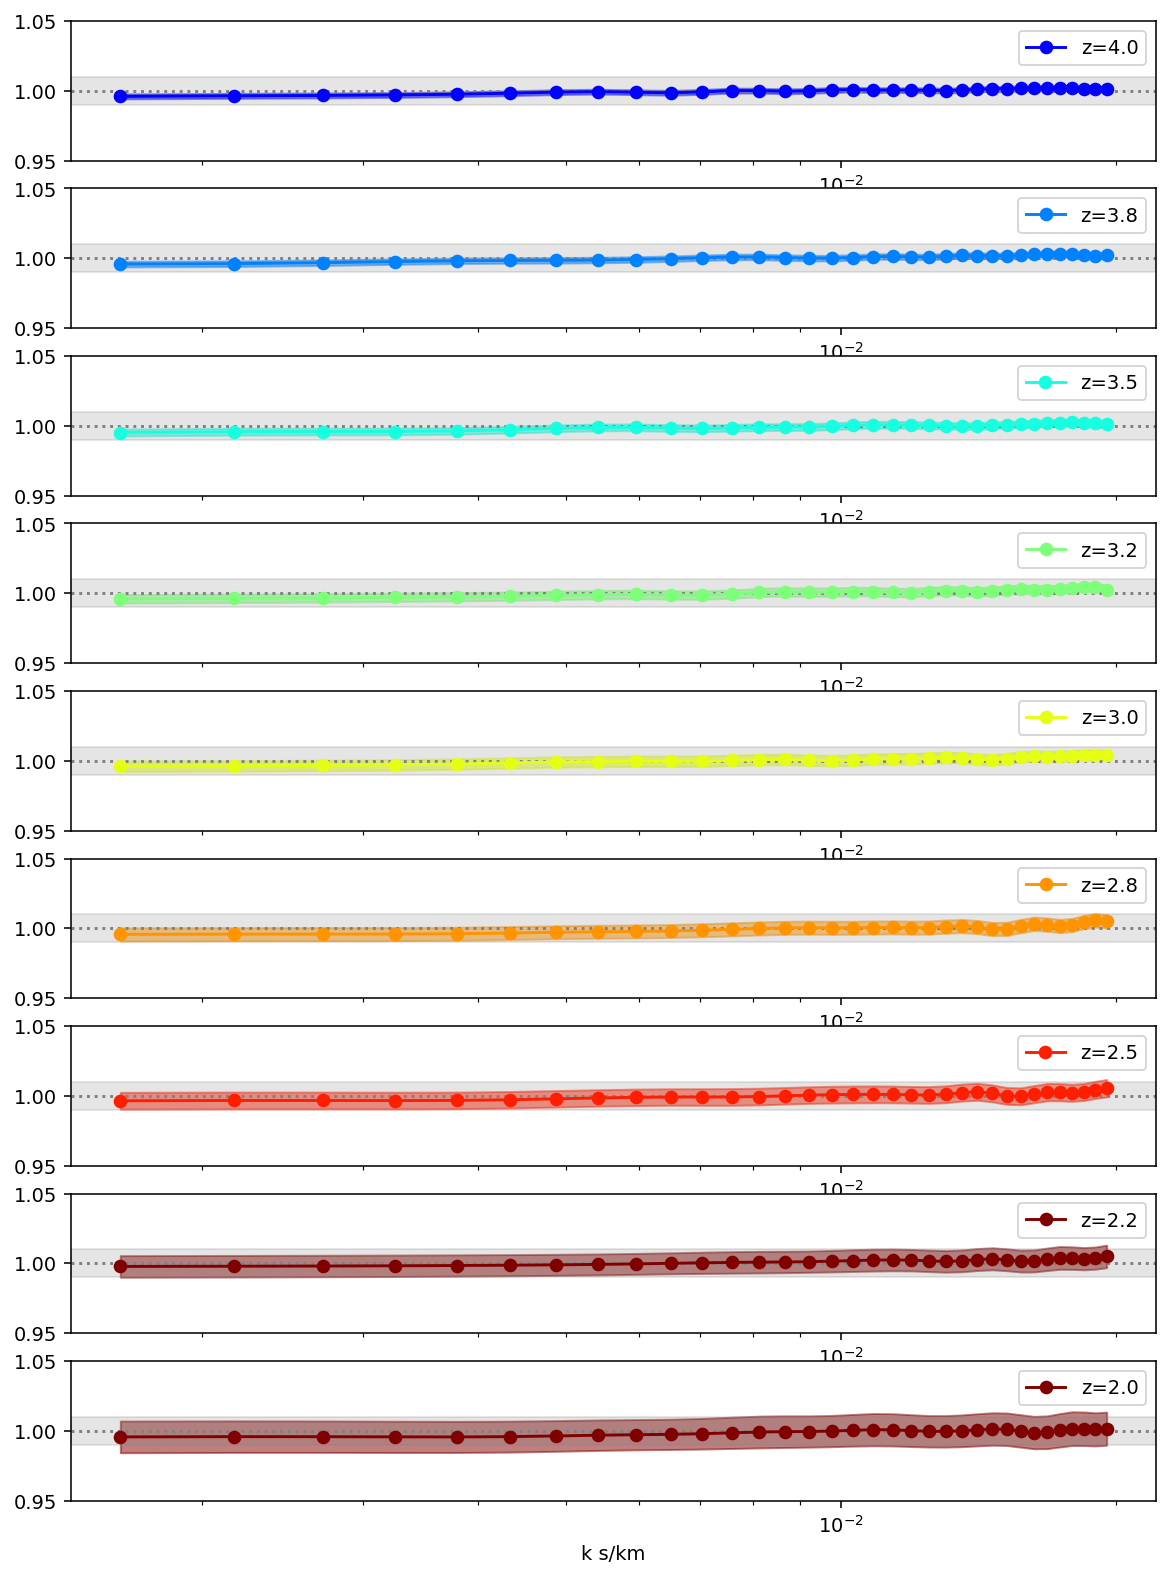

In [18]:
k_kms=data.k
k_emu_kms=np.logspace(np.log10(min(k_kms)),np.log10(max(k_kms)),500)
zs=data.z
Nz=len(zs)

# ask emulator prediction for P1D in each bin
emu_p1d, emu_cov = like_complete.get_p1d_kms(k_kms,values=None,return_covar=True)

emu_calls=like_complete.theory.get_emulator_calls(like.parameters_from_sampling_point(values=None))

plt.figure(figsize=[10,14])
dex=0
# plot only few redshifts for clarity
for iz in reversed(range(0,Nz)):
    plt.subplot(len(truth.data),1,len(truth.data)-(iz))
    if aa==0:
        plt.title("Predicted/truth, at the truth, velocity units")
    # acess data for this redshift
    z=zs[iz]
    p1d_data=data.get_Pk_iz(iz)
    p1d_cov=data.get_cov_iz(iz)
    p1d_theory=emu_p1d[iz]
    cov_theory=emu_cov[iz]
    
    # plot everything
    col = plt.cm.jet((len(truth.data)-iz)/(Nz-1))
    plt.axhspan(0.99,1.01,color="gray",alpha=0.2)
    plt.axhline(1,linestyle=":",color="gray")
    plt.plot(k_kms,p1d_theory/p1d_data,color=col,linestyle="solid",marker="o",label="z=%.1f" % z)
    plt.fill_between(k_kms,(p1d_theory+np.sqrt(np.diag(cov_theory)))/p1d_data,
            (p1d_theory-np.sqrt(np.diag(cov_theory)))/p1d_data,alpha=0.5,color=col)
    plt.xscale("log")
    plt.ylim(0.95,1.05)
    plt.legend()
    
plt.xlabel("k s/km")
plt.show()

Interestingly we still get $1\%$ error at low z when including the truth. Either way I don't think emulator inaccuracy here can be related to the remaining bias in the likelikhood scans.